# goal of this is to look at the gateway transport for the season

Compute Total Heat Transport (AW Inflow vs. Local Heat Content)

Q_AW = rhoCp integral over depth (u * T)dz

This notebook should be modified from the previous version to ID
- from the gateway transports, loaded from file, where are the indices of inflow and outflow at each gate
- can we compute a timeseries of heat transport for inflow and outflow

In [10]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

# ignore memory warnings
import warnings
warnings.filterwarnings('ignore')

In [11]:
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")

from get_Jterms import *

In [12]:
%run /home/mmurakami/crios_backups/an_helper_functions/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [13]:
# calculate the sea ice edge for 1 and 2
thresh = .15  # 15% sea ice coverage as Barton

# fig = plt.figure(figsize=(8,5))

# plot the basins, color by label
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan

# add the land
# plt.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap='RdBu')

In [14]:
# calculate the sea ice edge for 1 and 2
thresh = .15  # 15% sea ice coverage as Barton

# fig = plt.figure(figsize=(8,5))

# plot the basins, color by label
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan

# add the land
# plt.pcolormesh(get_aste_tracer(hfC,nfx,nfy)[0],cmap='RdBu')

In [15]:
# ocean and ice
AB_gT=0
AB_gS=0
dt_aste = 600
startyr = 2002
endyr = 2019              # for ASTE R1

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)
allyears = np.arange(2003,2018,1)

In [16]:
x_bso = gg['BarentsSeaOpening']["ix"]-1   # 0 
y_bso = gg['BarentsSeaOpening']["jy"]-1
x_bso[x_bso == 162] = 161

x_sfj = gg['Svalbard-FranzJosefIslands']["ix"]-1   # 1
y_sfj = gg['Svalbard-FranzJosefIslands']["jy"]-1
x_sfj,y_sfj = x_sfj[1:],y_sfj[1:]

x_fjnz = gg['FranzJosefIslands-NovayaZemlya']["ix"]-1  #2 
y_fjnz = gg['FranzJosefIslands-NovayaZemlya']["jy"]-1

# x_sta_vilkit = gg['StAnnaTrough/Voronin/Vilkitshogo']["ix"]-1  #3
# y_sta_vilkit = gg['StAnnaTrough/Voronin/Vilkitshogo']["jy"]-1

test = np.full(mskBasin.shape,np.nan)
test[y_bso,x_bso] = 1
test[y_sfj,x_sfj] = 2
test[y_fjnz,x_fjnz] = 3
# test[y_sta_vilkit,x_sta_vilkit] = 4

In [17]:
def line_orientation(x, y):
    orientations = np.array([])

    # Iterate through the list of points
    for i in range(1, len(x)):
        if x[i] == x[i - 1] and y[i] != y[i - 1]:
            orientations = np.append(orientations,"V") # vertical line add zonal transp
        elif y[i] == y[i - 1] and x[i] != x[i - 1]:
            orientations = np.append(orientations,"H") # horizontal line add meridional transp
        else:
            orientations = np.append(orientations,"V")  # fill na should be for top of vertical line (ie U)

    # the last one will be the same as the second to last orientation so we can keep consistent sizing
    orientations = np.append(orientations,orientations[-1])

    return orientations
choose_UV_bso = line_orientation(y_bso,x_bso)
choose_UV_sfj = line_orientation(y_sfj,x_sfj)
choose_UV_fjnz = line_orientation(y_fjnz,x_fjnz)

# start by loading the timeseries that we made at each gate

In [19]:
# To load later
loaded_data = np.load("/scratch2/mmurakami/aste_270x450x180/ASTER1/timeseries_data.npy", allow_pickle=True).item()

# Access the saved dictionaries
heat_transport_timeseries = loaded_data["heat_transport_timeseries"]   # contains ADV_TH positive into the barents sea (degC.m^3/s)
theta_timeseries = loaded_data["theta_timeseries"]                     # 
salt_timeseries = loaded_data["salt_timeseries"]
binned_theta_timeseries = loaded_data["binned_theta_timeseries"]
binned_salt_timeseries = loaded_data["binned_salt_timeseries"]


loaded_data = np.load("/scratch2/mmurakami/aste_270x450x180/ASTER1/timeseries_data_advslt.npy", allow_pickle=True).item()
salt_transport_timeseries = loaded_data["salt_transport_timeseries"] # contains ADV_SLT positive into the Barents Sea (PSU.m^3/s)

loaded_data = np.load("/scratch2/mmurakami/aste_270x450x180/ASTER1/timeseries_data_velmass.npy", allow_pickle=True).item()
velmass_timeseries = loaded_data["velmass_timeseries"] # contains UVEL and VVELMASS (m/s)

# identify indices of inflow and outflow

In [20]:
gates = velmass_timeseries.keys()
gates

dict_keys(['BSO', 'SFJ', 'FJNZ'])

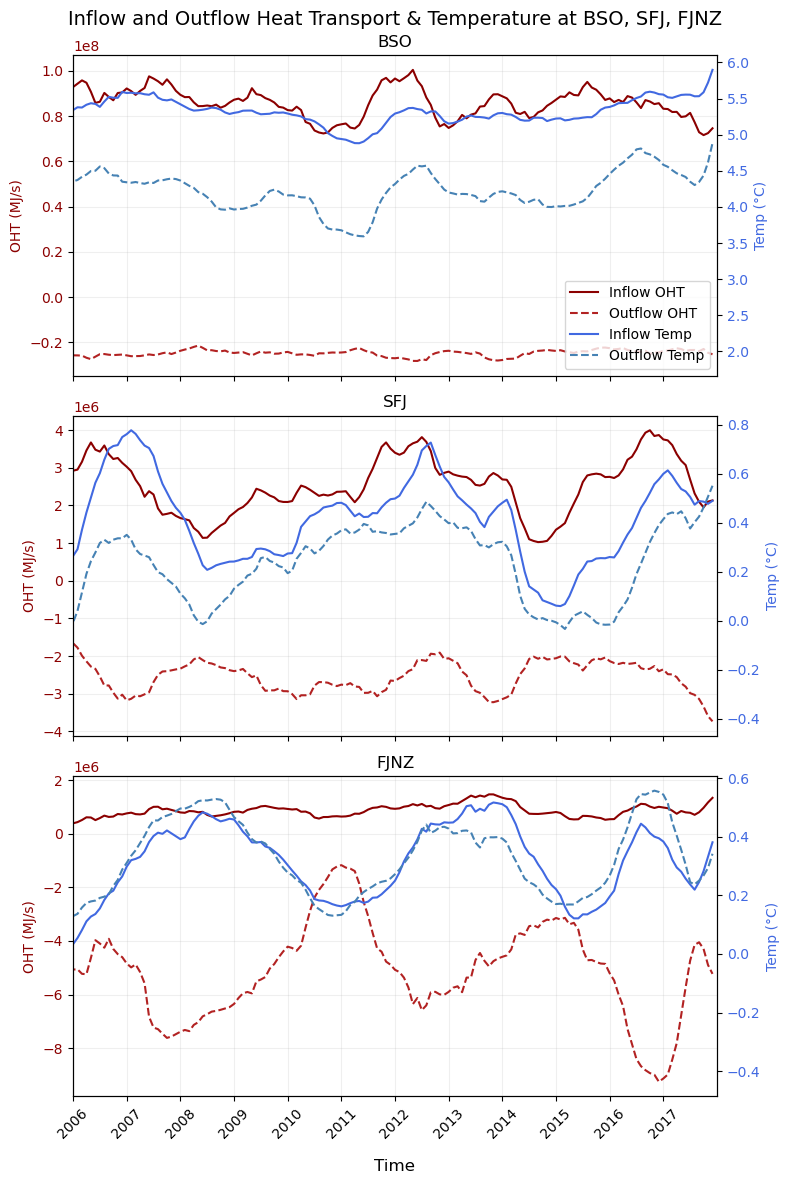

In [27]:
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

xtick_positions = np.arange(0, 15*12, 12)
xtick_labels = np.arange(2003, 2018)
time = np.arange(0, 15*12)
window_size = 12  # months

for i, gate in enumerate(gates):
    ax1 = axes[i]
    vel = velmass_timeseries[gate]
    theta = theta_timeseries[gate]
    Q = heat_transport_timeseries[gate] * myparms['rcp'] * 1e-6  # MJ/s

    # Masks
    inflow_mask = vel > 0
    outflow_mask = vel < 0

    # Temperature
    T_inflow = np.nansum(theta * inflow_mask, axis=(2, 3)) / np.nansum(inflow_mask, axis=(2, 3))
    T_outflow = np.nansum(theta * outflow_mask, axis=(2, 3)) / np.nansum(outflow_mask, axis=(2, 3))

    # Heat transport
    Q_inflow = np.nansum(Q * inflow_mask, axis=(2, 3))
    Q_outflow = np.nansum(Q * outflow_mask, axis=(2, 3))

    # Smooth
    heat_in_smooth = pd.Series(Q_inflow.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()
    heat_out_smooth = pd.Series(Q_outflow.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()
    temp_in_smooth = pd.Series(T_inflow.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()
    temp_out_smooth = pd.Series(T_outflow.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()

    # Plot heat transport
    ax1.plot(time, heat_in_smooth, color="darkred", label="Inflow OHT")
    ax1.plot(time, heat_out_smooth, color="firebrick", linestyle="--", label="Outflow OHT")
    ax1.set_ylabel("OHT (MJ/s)", color="darkred")
    ax1.tick_params(axis='y', labelcolor="darkred")
    ax1.set_title(f"{gate}")
    ax1.set_xticks(xtick_positions)
    ax1.set_xticklabels(xtick_labels, rotation=45)
    ax1.set_xlim(3*12, 15*12)
    ax1.grid(alpha=0.2)

    # Twin axis for temperature
    ax2 = ax1.twinx()
    ax2.plot(time, temp_in_smooth, color="royalblue", label="Inflow Temp")
    ax2.plot(time, temp_out_smooth, color="steelblue", linestyle="--", label="Outflow Temp")
    ax2.set_ylabel("Temp (°C)", color="royalblue")
    ax2.tick_params(axis='y', labelcolor="royalblue")
    ax2.set_xlim(3*12, 15*12)

    # Add combined legend only to the first subplot
    if i == 0:
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="lower right")

# Set shared x-label
fig.supxlabel("Time")
fig.suptitle("Inflow and Outflow Heat Transport & Temperature at BSO, SFJ, FJNZ", fontsize=14)
plt.tight_layout()

plt.savefig("figs/inout_timeseries.png",dpi=300)
plt.show()

In [30]:
mymsk = np.zeros((ny,nx))
idxs = np.where(mskBasin == 6)

for i,j in zip (idxs[0],idxs[1]):
    mymsk[i,j] = 1

In [31]:
# do the same plot but overlay with sea ice area instead
# do SIarea

# loop through the years to create the timeseries
alldatetimes = np.array([])
SIareas = np.zeros((len(allyears),12))

iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ## 
    # get the SIarea values

    SIarea = np.full((len(tsstr),ny,nx),np.nan)  # 2D field 
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'state_2d_set1'
        meta_state_2d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_2d_set1["fldList"])
        varnames = np.array(["SIarea"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        # this is wrong, this is the fractional area -- to get the actual area we need to multiply by RAC
        SIareai,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # m^2/m^2
        SIarea[i,:,:] = np.reshape(SIareai,(ny,nx))*mymsk*RAC  # m^2


        # get the total SIarea for that time
        if i in [10,11,0,1,2,3]:  # november-april
            SIareas[iy,i] = np.nansum(SIarea[i,:,:])
        else:
            SIareas[iy,i] = np.full(np.nansum(SIarea[i,:,:]).shape,np.nan)
        #alldatetimes = np.append(alldatetimes,datetimes[i])

    iy += 1

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


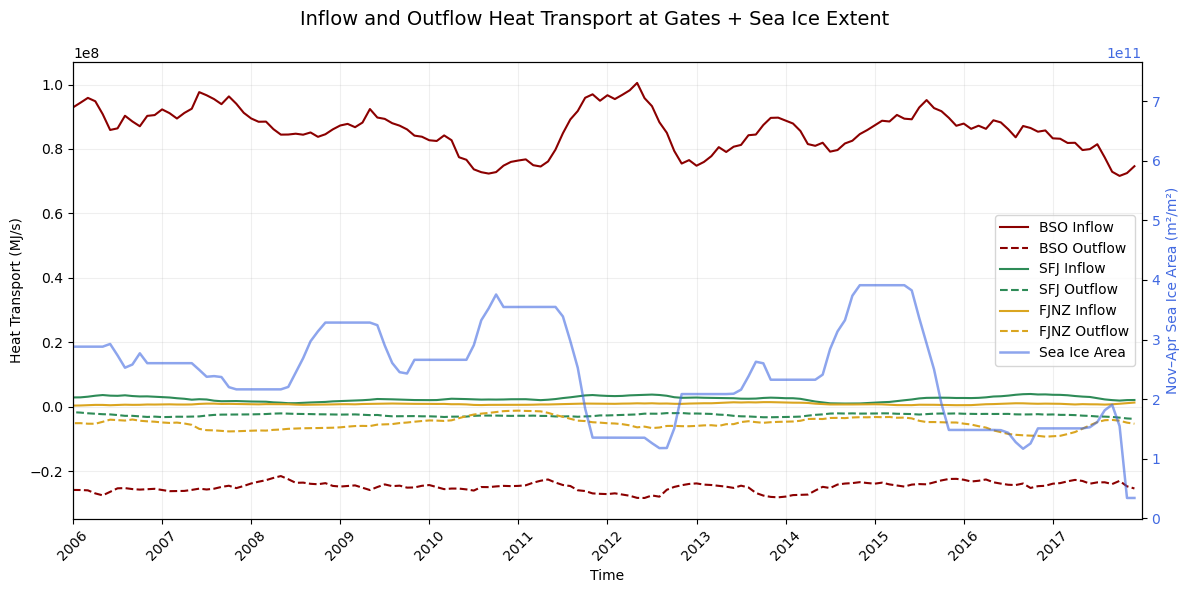

In [37]:
gates = ['BSO', 'SFJ', 'FJNZ']
# gates = ['SFJ', 'FJNZ']
colors = {'BSO': 'darkred', 'SFJ': 'seagreen', 'FJNZ': 'goldenrod'}
linestyles = {'inflow': '-', 'outflow': '--'}

window_size = 12
time = np.arange(0, 15 * 12)
xtick_positions = np.arange(0, 15 * 12, 12)
xtick_labels = np.arange(2003, 2018)

# Sea ice extent smoothing
SI_smoothed = pd.Series(SIareas.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()

# --- Create figure ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# --- Loop over gates and plot heat transport ---
for gate in gates:
    vel = velmass_timeseries[gate]
    Q = heat_transport_timeseries[gate] * myparms['rcp'] * 1e-6  # MJ/s

    inflow_mask = vel > 0
    outflow_mask = vel < 0

    Q_in = np.nansum(Q * inflow_mask, axis=(2, 3))
    Q_out = np.nansum(Q * outflow_mask, axis=(2, 3))

    heat_in_smooth = pd.Series(Q_in.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()
    heat_out_smooth = pd.Series(Q_out.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()

    ax1.plot(time, heat_in_smooth, label=f"{gate} Inflow", color=colors[gate], linestyle=linestyles['inflow'])
    ax1.plot(time, heat_out_smooth, label=f"{gate} Outflow", color=colors[gate], linestyle=linestyles['outflow'])

# --- Primary axis: Heat Transport ---
ax1.set_ylabel("Heat Transport (MJ/s)", color="black")
ax1.tick_params(axis='y', labelcolor="black")
ax1.set_xticks(xtick_positions)
ax1.set_xticklabels(xtick_labels, rotation=45)
ax1.set_xlim(3 * 12, 15 * 12)
ax1.grid(alpha=0.2)

# --- Twin axis: Sea Ice Extent ---
ax2 = ax1.twinx()
ax2.plot(time, SI_smoothed, color="royalblue", linewidth=1.8, alpha=0.6, label="Sea Ice Area")
ax2.set_ylabel("Nov–Apr Sea Ice Area (m²/m²)", color="royalblue")
ax2.tick_params(axis='y', labelcolor="royalblue")
ax2.set_xlim(3 * 12, 15 * 12)

# --- Legends ---
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="center right")

# --- Labels and Title ---
ax1.set_xlabel("Time")
fig.suptitle("Inflow and Outflow Heat Transport at Gates + Sea Ice Extent", fontsize=14)

plt.tight_layout()

# plt.savefig("figs/heat_ice_timeseries_withoutBSO.png",dpi=300)

plt.show()

# it makes sense to subdivide these gates more based on the water masses themselves

In [ ]:
# do a T-S diagram with the labels 




In [ ]:
# plot the average per-season T and S profile at each of the gates and see what is 

# do some plots of the gates themselves

In [38]:
# **Define seasons (with DJF using December from the previous year)**
seasons = {
    "DJF": {"prev_dec": True, "months": [0, 1]},  # December (prev year) + Jan, Feb
    "MAM": {"prev_dec": False, "months": [2, 3, 4]},  # Mar, Apr, May
    "JJA": {"prev_dec": False, "months": [5, 6, 7]},  # Jun, Jul, Aug
    "SON": {"prev_dec": False, "months": [8, 9, 10]}  # Sep, Oct, Nov
}

In [36]:
# Compute distances dynamically for each gate
gate_distances = {}

gate_labels = gates

for gate, (x_gate, y_gate, choose_UV_gate) in zip(gate_labels, [(x_bso, y_bso, choose_UV_bso), 
                                                                (x_sfj, y_sfj, choose_UV_sfj), 
                                                                (x_fjnz, y_fjnz, choose_UV_fjnz)]):
    distance = np.array([])
    for i in range(len(x_gate)):
        thisy = y_gate[i]
        thisx = x_gate[i]
        this_choose = choose_UV_gate[i]
        
        if this_choose == 'H':
            distance = np.append(distance, mygrid['DYG'][thisy, thisx])
        else:
            distance = np.append(distance, mygrid['DXG'][thisy, thisx])

    gate_distances[gate] = np.cumsum(distance / 1000)  # Convert to km

# Compute depth array
depths = np.cumsum(-mygrid["DRF"])  # Convert to depth in meters

In [52]:
# Define distance along the gate (assuming uniform spacing)
x_gate = {gate: np.arange(theta_timeseries[gate].shape[2]) for gate in gate_labels}  # Distance index
x_labels = {
    "BSO": "km from Norway to SP",
    "SFJ": "km from SFJ to SP",
    "FJNZ": "km from NZ to SFJ"
}

# Loop through each year and create a 2x3 plot for temperature and salinity at each gate
for year_idx, year in enumerate(allyears):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=False, sharey=True)
    print(year)

    for gate_idx, gate in enumerate(gate_labels):
        # Extract annual averages
        theta_data = theta_timeseries[gate][year_idx]
        salt_data = salt_timeseries[gate][year_idx]

        # Mask zeros to NaN for better visualization
        theta_masked = np.where(theta_data == 0, np.nan, theta_data)
        salt_masked = np.where(salt_data == 0, np.nan, salt_data)

        # Generate x and y coordinates
        x_vals = gate_distances[gate]  # Distance along the gate in km
        x_min, x_max = x_vals.min(), x_vals.max()
        y_vals = np.cumsum(mygrid['DRF'])


        print('plotting' + gate)

        # Plot temperature
        ax1 = axes[0, gate_idx]
        im1 = ax1.imshow(theta_masked, cmap="coolwarm", aspect="auto",
                         extent=[x_vals.min(), x_vals.max(), y_vals.max(), y_vals.min()],vmin=-2,vmax=4)
        ax1.set_xlim(x_min, x_max)  # Set unique limits for each gate
        ax1.set_title(f"{gate} Temp {year}")
        if gate_idx == 0:
            ax1.set_ylabel("Depth (m)")
        if gate_idx == 2:
            cbar1 = fig.colorbar(im1, ax=ax1, orientation="vertical")
            cbar1.set_label("Temperature (°C)")

        # Plot salinity
        ax2 = axes[1, gate_idx]
        im2 = ax2.imshow(salt_masked, cmap="viridis", aspect="auto",
                         extent=[x_vals.min(), x_vals.max(), y_vals.max(), y_vals.min()],vmin=33,vmax=35)
        ax2.set_xlim(x_min, x_max)  # Set unique limits for each gate
        ax2.set_title(f"{gate} Salinity {year}")
        ax2.set_xlabel(x_labels[gate])  # Set custom x-axis label
        if gate_idx == 0:
            ax2.set_ylabel("Depth (m)")
        if gate_idx == 2:
            cbar2 = fig.colorbar(im2, ax=ax2, orientation="vertical")
            cbar2.set_label("Salinity (PSU)")

    # Adjust layout and save figure
    plt.tight_layout()
    plt.savefig(f"figs/gate_temp/Theta_Salt_Gates_{year}.png", dpi=300)
    plt.close()


2003
plottingBSO
plottingSFJ
plottingFJNZ
2004
plottingBSO
plottingSFJ
plottingFJNZ
2005
plottingBSO
plottingSFJ
plottingFJNZ
2006
plottingBSO
plottingSFJ
plottingFJNZ
2007
plottingBSO
plottingSFJ
plottingFJNZ
2008
plottingBSO
plottingSFJ
plottingFJNZ
2009
plottingBSO
plottingSFJ
plottingFJNZ
2010
plottingBSO
plottingSFJ
plottingFJNZ
2011
plottingBSO
plottingSFJ
plottingFJNZ
2012
plottingBSO
plottingSFJ
plottingFJNZ
2013
plottingBSO
plottingSFJ
plottingFJNZ
2014
plottingBSO
plottingSFJ
plottingFJNZ
2015
plottingBSO
plottingSFJ
plottingFJNZ
2016
plottingBSO
plottingSFJ
plottingFJNZ
2017
plottingBSO
plottingSFJ
plottingFJNZ


In [50]:
# also plot the anomalies for these based on the first 5 years
import numpy as np
import matplotlib.pyplot as plt

# Define distance along the gate (assuming uniform spacing)
x_labels = {
    "BSO": "km from Norway to SP (increasing toward SP)",
    "SFJ": "km from SFJ to SP (increasing toward SP)",
    "FJNZ": "km from NZ to SFJ (increasing toward SFJ)"
}

# Compute the mean over the first 5 years for each gate
theta_baseline = {gate: np.nanmean(theta_timeseries[gate][:5], axis=0) for gate in gate_labels}
salt_baseline = {gate: np.nanmean(salt_timeseries[gate][:5], axis=0) for gate in gate_labels}

# Loop through the last 10 years and create a 2x3 plot for anomaly temperature and salinity at each gate
for year_idx in range(-11, 0):  # Last 10 years
    year = allyears[year_idx]  # Extract corresponding year
    fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=False, sharey=True)
    print(f"Plotting anomaly for {year}")

    for gate_idx, gate in enumerate(gate_labels):
        # Compute anomaly (last 10 years - first 5 years mean)
        theta_anomaly = theta_timeseries[gate][year_idx] - theta_baseline[gate]
        salt_anomaly = salt_timeseries[gate][year_idx] - salt_baseline[gate]

        # Mask zeros to NaN for better visualization
        theta_masked = np.where(theta_anomaly == 0, np.nan, theta_anomaly)
        salt_masked = np.where(salt_anomaly == 0, np.nan, salt_anomaly)

        # Generate x and y coordinates
        x_vals = gate_distances[gate]  # Distance along the gate in km
        x_min, x_max = x_vals.min(), x_vals.max()
        y_vals = np.cumsum(mygrid['DRF'])

        print(f"Plotting {gate} anomaly for {year}")

        # Plot temperature anomaly
        ax1 = axes[0, gate_idx]
        im1 = ax1.imshow(theta_masked, cmap="RdBu_r", aspect="auto",
                         extent=[x_min, x_max, y_vals.max(), y_vals.min()], vmin=-2, vmax=2)
        ax1.set_xlim(x_min, x_max)  # Set unique limits for each gate
        ax1.set_title(f"{gate} Temp Anomaly {year}")
        if gate_idx == 0:
            ax1.set_ylabel("Depth (m)")
        if gate_idx == 2:
            cbar1 = fig.colorbar(im1, ax=ax1, orientation="vertical")
            cbar1.set_label("Temperature Anomaly (°C)")

        # Plot salinity anomaly
        ax2 = axes[1, gate_idx]
        im2 = ax2.imshow(salt_masked, cmap="BrBG", aspect="auto",
                         extent=[x_min, x_max, y_vals.max(), y_vals.min()], vmin=-0.6, vmax=0.6)
        ax2.set_xlim(x_min, x_max)  # Set unique limits for each gate
        ax2.set_title(f"{gate} Salinity Anomaly {year}")
        ax2.set_xlabel(x_labels[gate])  # Set custom x-axis label
        if gate_idx == 0:
            ax2.set_ylabel("Depth (m)")
        if gate_idx == 2:
            cbar2 = fig.colorbar(im2, ax=ax2, orientation="vertical")
            cbar2.set_label("Salinity Anomaly (PSU)")

    # Adjust layout and save figure
    plt.tight_layout()
    plt.savefig(f"figs/gate_anomaly/Theta_Salt_Gates_Anomaly_{year}.png", dpi=300)
    plt.close()

Plotting anomaly for 2007
Plotting BSO anomaly for 2007
Plotting SFJ anomaly for 2007
Plotting FJNZ anomaly for 2007
Plotting anomaly for 2008
Plotting BSO anomaly for 2008
Plotting SFJ anomaly for 2008
Plotting FJNZ anomaly for 2008
Plotting anomaly for 2009
Plotting BSO anomaly for 2009
Plotting SFJ anomaly for 2009
Plotting FJNZ anomaly for 2009
Plotting anomaly for 2010
Plotting BSO anomaly for 2010
Plotting SFJ anomaly for 2010
Plotting FJNZ anomaly for 2010
Plotting anomaly for 2011
Plotting BSO anomaly for 2011
Plotting SFJ anomaly for 2011
Plotting FJNZ anomaly for 2011
Plotting anomaly for 2012
Plotting BSO anomaly for 2012
Plotting SFJ anomaly for 2012
Plotting FJNZ anomaly for 2012
Plotting anomaly for 2013
Plotting BSO anomaly for 2013
Plotting SFJ anomaly for 2013
Plotting FJNZ anomaly for 2013
Plotting anomaly for 2014
Plotting BSO anomaly for 2014
Plotting SFJ anomaly for 2014
Plotting FJNZ anomaly for 2014
Plotting anomaly for 2015
Plotting BSO anomaly for 2015
Plotting